In [1]:
# === Script propre : Comparaison de 9 modèles ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix




In [2]:
# === Fonctions ===
def business_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1][0]
    fp = cm[0][1]
    return 10 * fn + fp


In [3]:
# === 1. Chargement du train_clean.csv ===
print("\U0001F4C5 Chargement de train_clean.csv...")
data_path = Path.cwd().parent / "data" / "processed" / "train_clean.csv"
df = pd.read_csv(data_path)

X = df.drop(columns=["TARGET", "SK_ID_CURR"], errors='ignore')
y = df["TARGET"]



📅 Chargement de train_clean.csv...


In [4]:
# === 2. Split en train / test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\U0001F4DD Taille train : {X_train.shape}, test : {X_test.shape}")

📝 Taille train : (246005, 247), test : (61502, 247)


In [5]:
# === 3. Chargement des modèles ===
models_path = Path.cwd().parent / "src" / "models"
model_files = list(models_path.glob("*.pkl"))

In [6]:


# === 4. Comparaison ===
results = []

for model_path in model_files:
    model_name = model_path.stem
    try:
        print(f"\U0001F4C8 Evaluation du modèle : {model_name}")
        model = joblib.load(model_path)

        probas = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probas)

        thresholds = np.linspace(0.01, 0.99, 50)
        best_score = float('inf')
        best_threshold = 0.5

        for t in thresholds:
            preds = (probas >= t).astype(int)
            score = business_score(y_test, preds)
            if score < best_score:
                best_score = score
                best_threshold = t

        results.append({
            "Model": model_name,
            "Best_Threshold": best_threshold,
            "Business_Score": best_score,
            "AUC": auc
        })

    except Exception as e:
        print(f"⚠️ Erreur avec le modèle {model_name} : {e}")






📈 Evaluation du modèle : LightGBM_custom


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📈 Evaluation du modèle : LightGBM_pipeline


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📈 Evaluation du modèle : RandomForest_smote
📈 Evaluation du modèle : XGBoost_custom
📈 Evaluation du modèle : RandomForest_pipeline
📈 Evaluation du modèle : XGBoost_smote
📈 Evaluation du modèle : XGBoost_pipeline
📈 Evaluation du modèle : RandomForest_custom
📈 Evaluation du modèle : LightGBM_smote


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [7]:
# === 5. Résultats ===
results_df = pd.DataFrame(results)

print("\n\U0001F4CA Résultats comparatifs :")
print(results_df.sort_values("AUC", ascending=False))


📊 Résultats comparatifs :
                   Model  Best_Threshold  Business_Score       AUC
5          XGBoost_smote            0.85           31008  0.789658
1      LightGBM_pipeline            0.11           33926  0.742690
4  RandomForest_pipeline            0.09           35992  0.713099
6       XGBoost_pipeline            0.13           37231  0.702211
8         LightGBM_smote            0.71           42243  0.643731
0        LightGBM_custom            0.11           43050  0.624320
2     RandomForest_smote            0.91           44905  0.603442
3         XGBoost_custom            0.07           45039  0.593798
7    RandomForest_custom            0.13           48930  0.553954


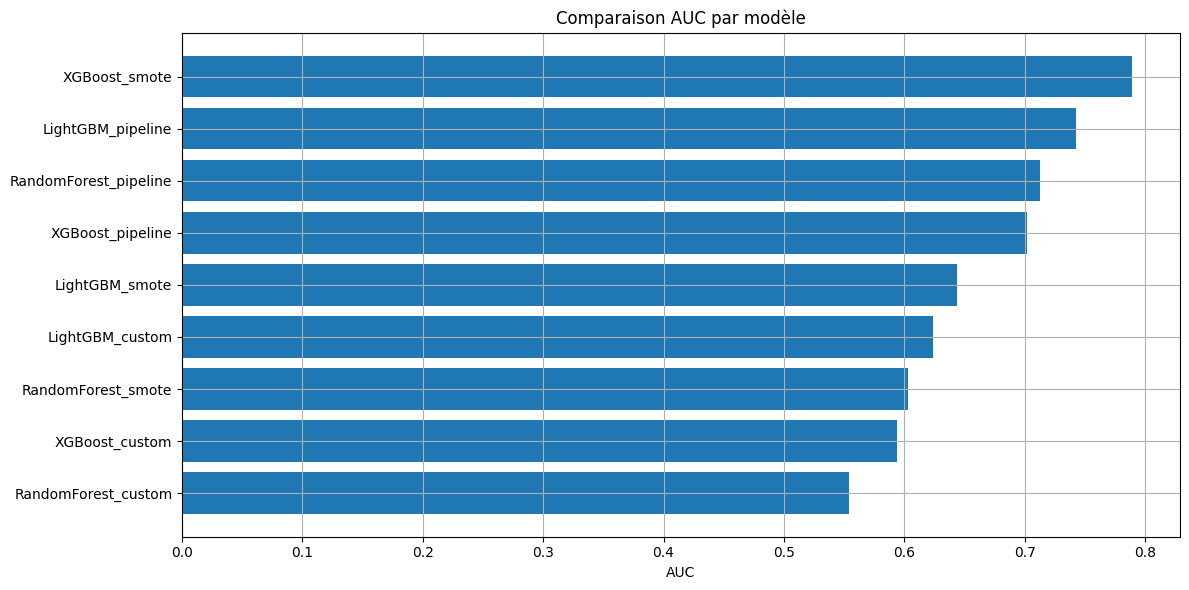

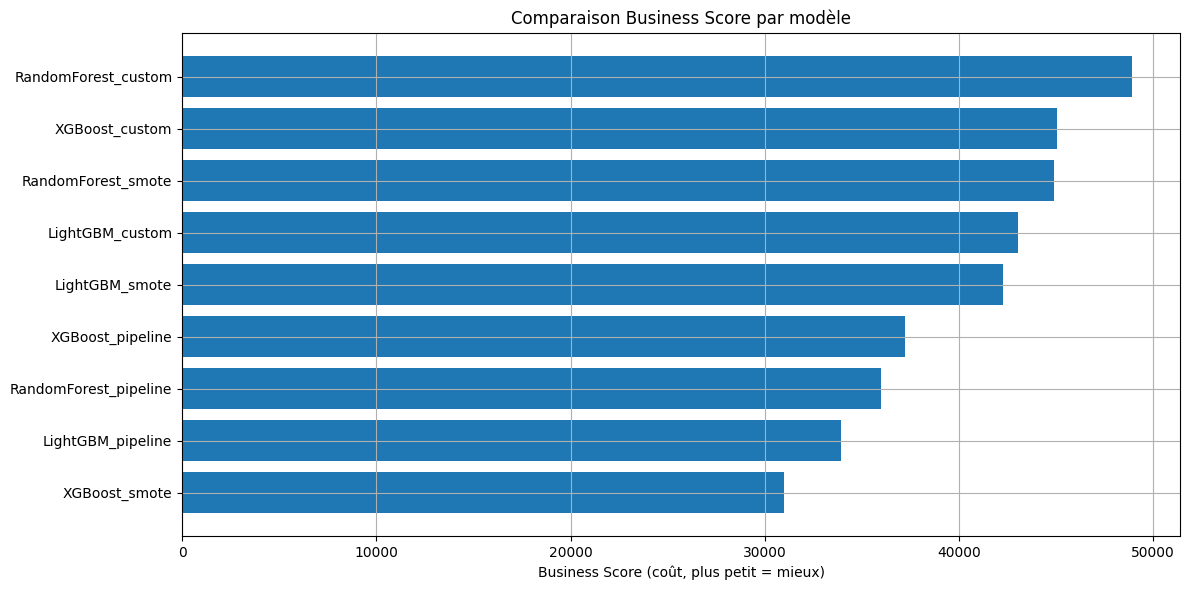

In [8]:
# === 6. Graphiques ===

# Tri pour affichage
results_df = results_df.dropna()

plt.figure(figsize=(12, 6))
plt.barh(results_df.sort_values("AUC")["Model"], results_df.sort_values("AUC")["AUC"])
plt.xlabel("AUC")
plt.title("Comparaison AUC par modèle")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(results_df.sort_values("Business_Score")["Model"], results_df.sort_values("Business_Score")["Business_Score"])
plt.xlabel("Business Score (coût, plus petit = mieux)")
plt.title("Comparaison Business Score par modèle")
plt.grid(True)
plt.tight_layout()
plt.show()